<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

## Chatbot: catégorisations et prévisions des réponses aux questions

# Text Mining et Catégorisation de Produits en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="R"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="R"/></a>

## Introduction

Il s'agit de prévoir la réponse à une question à partir de son sujet. Seule la catégorie principale (1er niveau) est prédite mais nous pourrons essayer d'affiner par la suite. L'objectif est plutôt de comparer les performances des méthodes et technologies en fonction de la taille de la base d'apprentissage ainsi que d'illustrer sur un exemple complexe le prétraitement de données textuelles. La stratégie de sous ou sur échantillonnage des catégories qui permet d'améliorer la prévision va être mise en oeuvre. Nous allons essayer différentes techniques d'échantillonnage comme le regroupement de plusieurs catégories en fonction de leur points communs ou selon leur taille puis nous essayerons de mettre en place un mélange de upsampling et de downsampling.
* Nous allons réduire l'échantillon réduit en le séparant en 2 parties: apprentissage et validation. 
* Les données textuelles sont  nettoyées, racinisées, vectorisées avant modélisation.
* Trois modélisations sont estimées: logistique, arbre, forêt aléatoire.
* Optimiser l'erreur en faisant varier différents paramètres: types et paramètres de vectorisation (TF-IDF), paramètres de la régression logistique (pénalisation l1) et de la forêt aléatoire (nombre d'arbres et nombre de variables aléatoire).

Exécuter finalement le code pour différentes tailles (paramètre  `tauxTot` ci-dessous) de l'échantillon d'apprentissage et comparer les qualités de prévision obtenues. 

In [2]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import collections
import itertools
import csv
import warnings

from sklearn.cross_validation import train_test_split

In [3]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

## 1. Importation des données
Définition du répertoir de travail, des noms des différents fichiers utilisés et des variables globales.


In [4]:
# Répertoire de travail
DATA_DIR = "/home/bouchero/Documents/projet/INSA_wefight_data_clean.csv"

# Nom des fichiers
training_reduit_path = DATA_DIR 
# Variable Globale
HEADER_TEST = ['Question','Intent','BlockId', 'Action']
HEADER_TRAIN =['Question','Intent','BlockId', 'Action']

In [17]:
## Si nécessaire (première exécution) chargement de nltk, librairie pour la suppression 
## des mots d'arrêt et la racinisation
## nltk.download()

   ### Read & Split Dataset
   Fonction permettant de lire le fichier d'apprentissage et de créer deux DataFrame Pandas, un pour l'apprentissage, l'autre pour la validation.
   La première méthode créée un DataFrame en lisant entièrement le fichier. Puis elle scinde le DataFrame en deux  grâce à la fonction dédiée de sklearn. 

In [5]:
def split_dataset(input_path, nb_line, tauxValid,columns):
    time_start = time.time()
    data_all = pd.read_csv(input_path,sep=",",names=columns,nrows=nb_line) #cree data frame
    data_all = data_all.fillna("") #remplace les na par " "
    data_train, data_valid = train_test_split(data_all, test_size = tauxValid) # Split arrays or matrices into random train and test subsets
    time_end = time.time()
    print("Split Takes %d s" %(time_end-time_start))
    return data_train, data_valid

nb_line=20000  # part totale extraite du fichier initial ici déjà réduit
tauxValid=0.10 # part totale extraite du fichier initial ici déjà réduit
data_train, data_valid = split_dataset(training_reduit_path, nb_line, tauxValid, HEADER_TRAIN)
data_all = pd.read_csv(training_reduit_path,sep=",",names=HEADER_TRAIN,nrows=nb_line) #cree data frame
# Cette ligne permet de visualiser les 5 premières lignes de la DataFrame 
data_train.head(5)

Split Takes 0 s


,Question,Intent,BlockId,Action
727,Je voudras savoir à quels aliments je n ai pa...,#2-130_QVDP_Alimentation,5991c543e4b0b2045b0c568f,wiki_cancer
77,comment accompagner mon amie ayant un cancer d...,#1-5_Menu_Aidant,59932112e4b068eebad2ef7e,wiki_cancer
205,les banques me refusent le prêt,#2-103_QVDP_Social_Banque,598b44d9e4b03f0d36dbfd76,wiki_cancer
4945,met moi un rendez vous pour Mercredi prochain,conversation_rappel_rendezvous,596340b8e4b0a226d0f4e811,conversation_rappelRendezVous
2879,j'ai une plaque rouge sèche sur le visage,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer


## 2. Nettoyage des données
Afin de limiter la dimension de l'espace des variables ou *features*, tout en conservant les informations essentielles, il est nécessaire de nettoyer les données en appliquant plusieurs étapes:
* Chaque mot est écrit en minuscule.
* Les termes numériques, de ponctuation et autres symboles sont supprimés.
* 155 mots-courants, et donc non informatifs, de la langue française sont supprimés (STOPWORDS). Ex: le, la, du, alors, etc...
* Chaque mot est "racinisé", via la fonction `STEMMER.stem` de la librairie nltk. La racinisation transforme un mot en son radical ou sa racine. Par exemple, les mots: cheval, chevaux, chevalier, chevalerie, chevaucher sont tous remplacés par "cheva".

### Importation des librairies et fichier pour le nettoyage des données.

In [6]:
# Librairies 
from bs4 import BeautifulSoup #Nettoyage d'HTML
import re # Regex
import nltk # Nettoyage des données

## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords = [unicode(w, "utf-8") for w in open("/home/bouchero/Documents/projet/lucene_stopwords.txt").read().split(",")] #En local

## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

## Fonction de setmming de stemming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')

### Fonction de nettoyage de texte
Fonction qui prend en intrée un texte et retourne le texte nettoyé en appliquant successivement les étapes suivantes: Nettoyage des données HTML, conversion en texte minuscule, encodage uniforme, suppression des caractéres non alpha numérique (ponctuations), suppression des stopwords, racinisation de chaque mot individuellement.

In [7]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text() #nettoyage donnee html
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore')
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens = [stemmer.stem(token) for token in tokens]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens)
    #join() returns a string in which the string elements of sequence have been joined by str separator.

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

### Nettoyage des DataFrames
Applique le nettoyage sur toutes les lignes de la DataFrame

In [8]:
# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Question','Intent','BlockId', 'Action']):
    #Test if columns entry match columns names of input data
    column_names_diff= set(column_names).difference(set(input_data.columns))
    #set.difference   new set with elements in column_names but not in input_data.columns
    
    if column_names_diff: #rentre dans la boucle si column_names différent zero
        # warning = exception
        warnings.warn("Column(s) '"+", ".join(list(column_names_diff)) +"' do(es) not match columns of input data", Warning)
        
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Question":
            array_clean = np.array(map(clean_txt,column))
            
        elif column_name == "Intent":
            array_clean = np.asarray(input_data['Intent']) #on recopie telle quelle la colonne intent  
            
        else:
            array_clean = np.array(map(clean_marque,column))
            #applies a function to all the items in an input_list
            #map(function_to_apply, list_of_inputs)
        clean_list.append(array_clean)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    return data_clean

In [9]:
# Take approximately 2 minutes fors 100.000 rows
data_valid_clean = clean_df(data_valid)
data_train_clean = clean_df(data_train)
#data_all_clean= clean_df(data_all)

Start Clean 502 lines
Cleaning time: 0 secondes
Start Clean 4511 lines
Cleaning time: 5 secondes


Affiche les 5 premières lignes de la DataFrame d'apprentissage après nettoyage.

In [10]:
#info sur les données
data_train_clean.info()
data_train_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4511 entries, 0 to 4510
Data columns (total 4 columns):
Question    4511 non-null object
Intent      4511 non-null object
BlockId     4511 non-null object
Action      4511 non-null object
dtypes: object(4)
memory usage: 141.0+ KB


,Question,Intent,BlockId,Action
0,voudr savoir aliment droit sach canc hormono d...,#2-130_QVDP_Alimentation,5991c543e4b0b2045b0c568f,wiki_cancer
1,accompagn ami canc sein,#1-5_Menu_Aidant,59932112e4b068eebad2ef7e,wiki_cancer
2,banqu refusent pret,#2-103_QVDP_Social_Banque,598b44d9e4b03f0d36dbfd76,wiki_cancer
3,met rend mercred prochain,conversation_rappel_rendezvous,596340b8e4b0a226d0f4e811,conversation_rappelrendezvous
4,plaqu roug sech visag,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer


In [11]:
# comptage du nbre d'occurence de categorie puis comptage du nbre de categorie differente
print(data_train["Action"].value_counts())
print("nb Action differente",(data_train["Action"].value_counts()).shape)

wiki_cancer                                          4241
                                                       82
conversation_rappelRendezVous                          82
conversation_rappelRead                                31
conversation_rappelUpdate2                             18
wiki_cancer#                                           13
conversation_FichePatientRead                          11
conversation_FichePatientUpdate                         7
conversation_hist                                       5
conversation_FichePatientWrite:age                      4
conversation_FichePatientWrite:doseTraitement           3
conversation_FichePatientWrite:newsletter               2
conversation_FichePatientWrite:typeTraitement           2
conversation_rappelUpdate                               2
conversation_FichePatientWrite:rappels                  2
conversation_FichePatientWrite:partagerTemoignage       1
conversation_FichePatientWrite:recevoirTemoignage       1
conversation_F

In [12]:
# comptage u nbre d'occurence de categorie puis comptage du nbre de categorie differente
print(data_train["Intent"].value_counts())
print("nb intent differente",(data_train["Intent"].value_counts()).shape)

#6-49_TRTEINS_Peau                             196
#6-97_TRTEINS_Nausees_Vomissements             130
#6-92_TRTEINS_Diarrhee                         128
#2-130_QVDP_Alimentation                       122
#6-53_TRTEINS_Aphtes                           116
#6-90_TRTEINS_Mauvais_Gout                     105
#6-98_TRTEINS_EI_Frequents                     101
#2-36_QVDP_Alopecie_Pourquoi                   101
#9-2_Informations_cancer                        94
#6-60_TRTEINS_PAC                               86
#2-64-0_QVDP_Fatigue                            84
#6-18_TRTEINS_Radiotherapie                     83
conversation_rappel_rendezvous                  82
#6-57_TRTEINS_Yeux_Secs                         81
#2-55_QVDP_Douleur                              79
#6-96_TRTEINS_Perte_Poids                       78
#2-45_QVDP_Alopecie_Perruque                    76
#6-1_TRTEINS_Chimiotherapie                     73
#2-96_QVDP_Social_Priseencharge                 71
#6-24_TRTEINS_hormonotherapie  

In [13]:
#on enregistre le contenu de la colonne Question dans un fichier csv
#on fait ensuite un wordcloud sur toutes les donnees
description = data_train_clean["Question"]
description.to_csv('Question.csv', sep = ',')

In [14]:
# tri par catégorie, on a un data frame pour une catégorie
df = data_train_clean[data_train_clean['Intent'] == "#6-49_TRTEINS_Peau"]
df.head()

,Question,Intent,BlockId,Action
4,plaqu roug sech visag,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
45,trait peau pel,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
53,main roug,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
76,crem hydrat,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
84,peau pel,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer


# 3. Création méta-catégories

In [15]:
#meta classe

categories = data_train_clean['Intent']
#categories = data_all['Intent']
tailleCat = int(np.shape(categories)[0])
LabelCat = np.zeros(tailleCat)
for k in range(tailleCat):
    # la categorie #0 a le label 0 implicitement
    if categories[k][0:2]=='Pr':  LabelCat[k] = 11#profile
    if (categories[k][0:2] == 'co' or categories[k][0:2]=='Co'): LabelCat[k] = 10 #conversation_rappel_rendezvous
    if categories[k][0:2] == '#1' : LabelCat[k] = 1
    if categories[k][0:2] == '#2' : LabelCat[k] = 2
    if categories[k][0:2] == '#3' : LabelCat[k] = 3 ##il y a personne dedans 
    if categories[k][0:2] == '#4' : LabelCat[k] = 4  ## il y a personne dedans
    if categories[k][0:2] == '#5' : LabelCat[k] = 5
    if categories[k][0:2] == '#6' : LabelCat[k] = 6
    if categories[k][0:2] == '#7' : LabelCat[k] = 7
    if categories[k][0:2] == '#8' : LabelCat[k] = 8
    if categories[k][0:2] == '#9' : LabelCat[k] = 9

In [16]:
#data frame avec une colonne mettant un label suivant la meta categorie
dfLabelCat = pd.DataFrame(LabelCat)
meta_df = pd.concat([data_train_clean, dfLabelCat], axis=1)
meta_df.head()

,Question,Intent,BlockId,Action,0
0,voudr savoir aliment droit sach canc hormono d...,#2-130_QVDP_Alimentation,5991c543e4b0b2045b0c568f,wiki_cancer,2.0
1,accompagn ami canc sein,#1-5_Menu_Aidant,59932112e4b068eebad2ef7e,wiki_cancer,1.0
2,banqu refusent pret,#2-103_QVDP_Social_Banque,598b44d9e4b03f0d36dbfd76,wiki_cancer,2.0
3,met rend mercred prochain,conversation_rappel_rendezvous,596340b8e4b0a226d0f4e811,conversation_rappelrendezvous,10.0
4,plaqu roug sech visag,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer,6.0


In [17]:
#on stocke les questions pour chaque cle, chaque cle sera une categorie
dix = []
neuf = []
huit = []
sept = []
six = []
cinq = []
quatre = []
trois = []
deux = []
un = []
zero = []
onze = []
for k in range(tailleCat):
    if meta_df[0][k] == 10.0 : dix.append(meta_df['Question'][k])
    if meta_df[0] [k] == 9.0 : neuf.append (meta_df['Question'][k])
    if meta_df[0][k] == 8.0 : huit.append (meta_df['Question'][k])
    if meta_df[0][k] == 7.0 : sept.append (meta_df['Question'][k])
    if meta_df[0][k] == 6.0 : six.append (meta_df['Question'][k])
    if meta_df[0][k] == 5.0 : cinq.append (meta_df['Question'][k])
    if meta_df[0][k] == 4.0 : quatre.append(meta_df['Question'][k])
    if meta_df[0][k] == 3.0 : trois.append (meta_df['Question'][k])
    if meta_df[0][k] == 2.0 : deux.append (meta_df['Question'][k])
    if meta_df[0][k] == 1.0 : un.append (meta_df['Question'][k])
    if meta_df[0][k] == 0.0 : zero.append (meta_df['Question'][k])
    if meta_df[0][k] == 11.0 : onze.append (meta_df['Question'][k])    
label = range(12)
questionLab = [zero,un,deux,trois,quatre,cinq,six,sept,huit,neuf,dix,onze]

meta_dict = dict(zip(label,questionLab)) # creation du dictionnaire

In [31]:
from os import path
from wordcloud import WordCloud

# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 6.0]#traitements
df.to_csv('Question.csv', sep = ',')
text = open("/home/bouchero/Documents/projet/Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


ImportError: No module named wordcloud

ci dessus le wordcloud sur la meta categ 6 : traitement. On retiendra comme stopwords pour cette catgéorie les mots suivants: chimiothérapie, nausée, peau et diarhée. 

In [ ]:
# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 9.0]#information

description3 = df
description3.to_csv('Question.csv', sep = ',')
text = open("/home/bouchero/Documents/projet/Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


On retiendra comme stopwords pour la catégorie information les mots suivants: cancer, sein et metastase 

In [ ]:
from os import path
from wordcloud import WordCloud

# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 2.0]#qvdp
df.to_csv('Question.csv', sep = ',')
text = open("/home/bouchero/Documents/projet/Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie qvdp les mots suivants: chimiothérapie, cancer,radiothérapie, fatigue et perruque

In [ ]:
from os import path
from wordcloud import WordCloud

# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 1.0]#menu
df.to_csv('Question.csv', sep = ',')
text = open("/home/bouchero/Documents/projet/Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie menu les mots suivants: ami, traitement, patient, cancer et sein

In [ ]:
from os import path
from wordcloud import WordCloud

# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 8.0]#ddp
df.to_csv('Question.csv', sep = ',')
text = open("/home/bouchero/Documents/projet/Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie ddp les mots suivants: patient, medical, fin et consentement

In [ ]:
# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 7.0]#qvda remission recidive

description3 = df
description3.to_csv('Question.csv', sep = ',')
text = open("/home/bouchero/Documents/projet/Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie qvda remission récidive les mots suivants: rémission, récidive, cancer et peut (pouvoir).

In [ ]:
# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 11.0]#profile

description3 = df
description3.to_csv('Question.csv', sep = ',')
text = open("/home/bouchero/Documents/projet/Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie profile les mots suivants: fiche, profil et veux.

In [ ]:
# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 0.0]#gestion

description3 = df
description3.to_csv('Question.csv', sep = ',')
text = open("/home/bouchero/Documents/projet/Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie gestion les mots suivants: message, cancer, information et besoin.

In [ ]:
# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 5.0]#soutien

description3 = df
description3.to_csv('Question.csv', sep = ',')
text = open("/home/bouchero/Documents/projet/Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie soutien les mots suivants: malade, dépression, peur et cancer.

In [ ]:
# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 10.0]#conversation

description3 = df
description3.to_csv('Question.csv', sep = ',')
text = open("/home/bouchero/Documents/projet/Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie conversation les mots suivants: rappel, prendre et voir.

In [22]:
meta = meta_df[0] # meta catégorie

color_seq = [] #liste de couleurs

#on associe à chaque individu une couleur en fonction de sa classe
for k in range(int(np.shape(meta_df['Question'])[0])):
    if meta[k] == 1.0 : color_seq.append("black")
    elif meta[k] == 2.0: color_seq.append("red")
    elif meta[k] == 11.0: color_seq.append("green")
    elif meta[k] == 10.0: color_seq.append("yellow")
    elif meta[k] == 5.0: color_seq.append("fuchsia")
    elif meta[k] == 6.0: color_seq.append("aqua")
    elif meta[k] == 7.0: color_seq.append("brown")
    elif meta[k] == 8.0: color_seq.append("indigo")
    elif meta[k] == 9.0: color_seq.append("lightblue")
    else : color_seq.append("blue")

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction import FeatureHasher

stop_words = nltk.corpus.stopwords.words('french')
question = meta_df["Question"] #on va travailler que sur la colonne des questions
vec = TfidfVectorizer(
            min_df = 1, #on prend tous les mots
            stop_words =stop_words,
            smooth_idf=True,
            norm='l2',
            sublinear_tf=True,
            use_idf=True, #tf avec idf
            ngram_range=(1,1)) # BIEN REFLECHIR COMMENT L UTILISER
tfidf =  vec.fit_transform(question)
# définition de la commande
X = tfidf
nom = vec.get_feature_names() #on recupere le nom des variables
svd = TruncatedSVD(n_components=30, n_iter=40, random_state=42)
svd.fit(X)
#variance expliquee
print(svd.explained_variance_ratio_) 
print (" ")
#valeurs singuliere
print(svd.singular_values_)
C = svd.fit(X).transform(X)


[ 0.01392177  0.0114489   0.01192129  0.01088641  0.00962354  0.00970538
  0.00943981  0.00883552  0.00850303  0.00834752  0.00794849  0.00759369
  0.00719502  0.00717743  0.00668761  0.00650444  0.00638047  0.00600904
  0.00588737  0.00572599  0.00546755  0.00549     0.00542904  0.00538856
  0.00510949  0.00507102  0.00501461  0.004815    0.00476687  0.00474873]
 
[ 9.2204207   7.76867674  7.29312691  6.96604778  6.73496666  6.60756973
  6.48746047  6.28369386  6.20391731  6.10048867  5.99482841  5.82103499
  5.70177603  5.66796569  5.45985772  5.40650629  5.35153088  5.22945468
  5.1251244   5.05823082  4.98038276  4.94688763  4.91942015  4.91290749
  4.78076563  4.75521754  4.73075123  4.63771663  4.6160101   4.60077069]


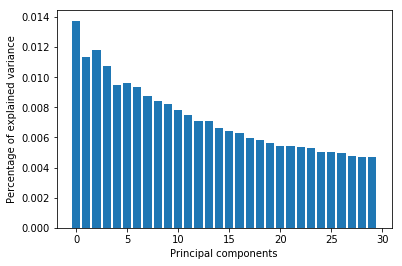

In [24]:
# Eboulis des valeurs propres
plt.figure()
abscisse = np.arange(30)
plt.bar(abscisse,svd.explained_variance_)
plt.xlabel("Principal components")
plt.ylabel("Percentage of explained variance" )
plt.show()

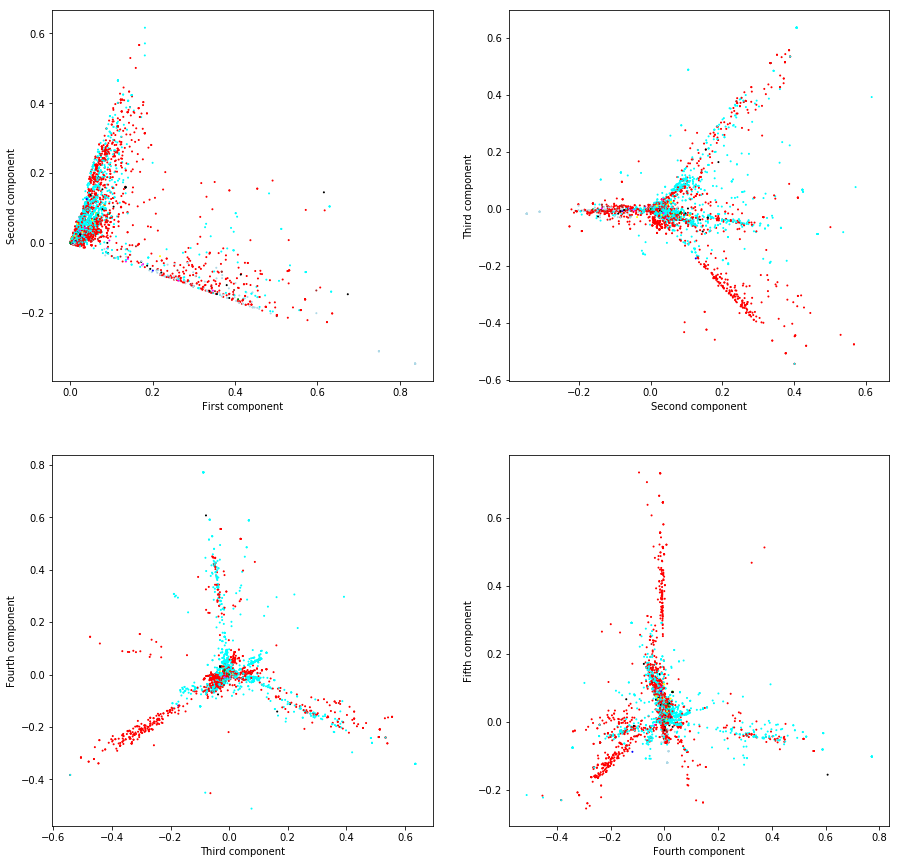

In [25]:
fig = plt.figure(figsize=(15,15))
# premier plan factoriel
ax = fig.add_subplot(2,2,1)
ax.scatter(C[:,0], C[:,1], s=1,c = color_seq)
plt.xlabel("First component")
plt.ylabel("Second component")
# deuxieme plan factoriel
ax = fig.add_subplot(2,2,2)
ax.scatter(C[:,1], C[:,2], s=1,c = color_seq)
plt.xlabel("Second component")
plt.ylabel("Third component")
# troisieme plan factoriel
ax = fig.add_subplot(2, 2, 3)
ax.scatter(C[:,2], C[:,3], s=1,c = color_seq)
plt.xlabel("Third component")
plt.ylabel("Fourth component")
# quatrieme plan factoriel
ax = fig.add_subplot(2, 2, 4)
ax.scatter(C[:,3], C[:,4], s=1,c = color_seq)
plt.xlabel("Fourth component")
plt.ylabel("Fifth component")
plt.show()

en bleu clair : la meta categ traitement 
    en rouge : QVDP
        les autres on les voit pas : dans la suite visualisons sans les deux categ les + fournies

In [28]:
color_seq= [] #liste de couleurs

#on associe à chaque individu une couleur en fonction de sa classe
for k in range(int(np.shape(meta_df['Question'])[0])):
    if meta[k] == 1.0 : color_seq.append("None")
    elif meta[k] == 2.0: color_seq.append("None")
    elif meta[k] == 11.0: color_seq.append("green")
    elif meta[k] == 10.0: color_seq.append("yellow")
    elif meta[k] == 5.0: color_seq.append("fuchsia")
    elif meta[k] == 6.0: color_seq.append("None")
    elif meta[k] == 7.0: color_seq.append("brown")
    elif meta[k] == 8.0: color_seq.append("indigo")
    elif meta[k] == 9.0: color_seq.append("None")
    else : color_seq.append("None")

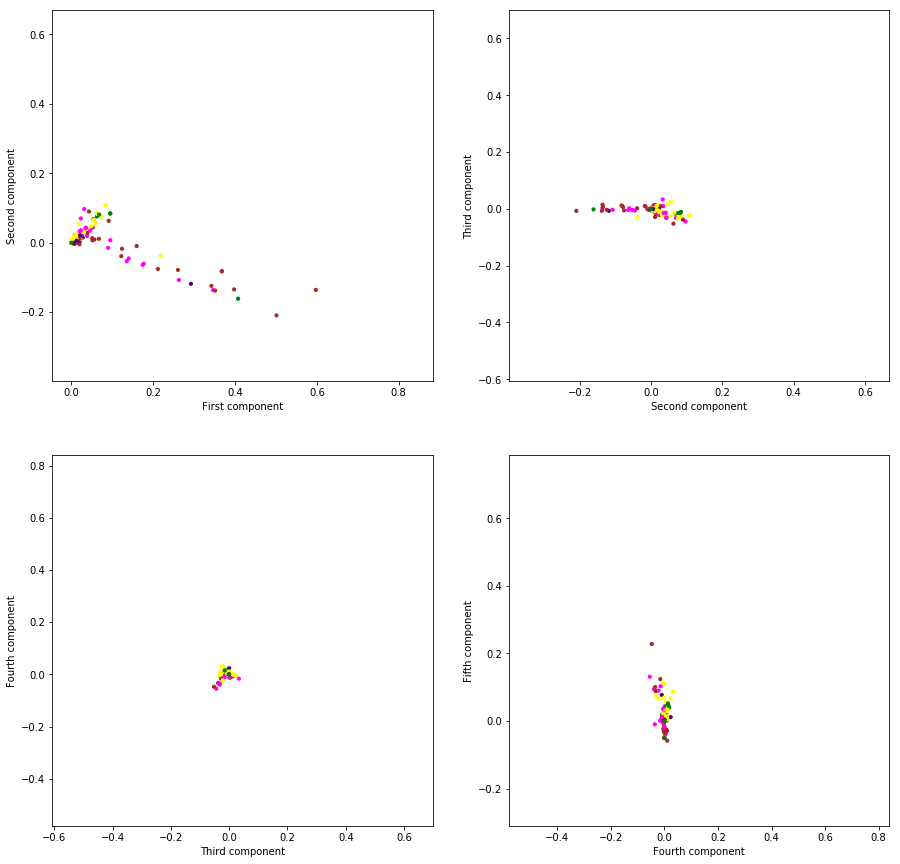

In [29]:
fig = plt.figure(figsize=(15,15))
# premier plan factoriel
ax = fig.add_subplot(2,2,1)
ax.scatter(C[:,0], C[:,1], s=10,c = color_seq)
plt.xlabel("First component")
plt.ylabel("Second component")
# deuxieme plan factoriel
ax = fig.add_subplot(2,2,2)
ax.scatter(C[:,1], C[:,2], s=10,c = color_seq)
plt.xlabel("Second component")
plt.ylabel("Third component")
# troisieme plan factoriel
ax = fig.add_subplot(2, 2, 3)
ax.scatter(C[:,2], C[:,3], s=10,c = color_seq)
plt.xlabel("Third component")
plt.ylabel("Fourth component")
# quatrieme plan factoriel
ax = fig.add_subplot(2, 2, 4)
ax.scatter(C[:,3], C[:,4], s=10,c = color_seq)
plt.xlabel("Fourth component")
plt.ylabel("Fifth component")
plt.show()

sur le 1er plan on voit un axe qui détermine très bien la meta categ 9 caractérisée donc par "sein" et "cancer"

### Essayons maintenant d'affiner notre classification avec l'ajout de stopwords en fonction des méta catégories

Nous avons 10 méta-catégories et 146 sous catégories. Nous allons effectuer des wordcloud pour chaque méta-catégorie. Avec ces wordcloud nous essayerons de repérer les 3-4 mots les plus représentatifs de la méta-catégorie. Ces mots sont par définition présents dans les sous catégories de la méta-catégorie. Nous allons donc rajouter ces mots aux stopwords afin d'affiner notre discrimination envers les sous catégories.

In [ ]:
#Création base de données non nettoyées
categories = data_all['Intent']
tailleCat = int(np.shape(categories)[0])
LabelCat = np.zeros(tailleCat)
for k in range(tailleCat):
    # la categorie #0 a le label 0 implicitement
    if categories[k][0:2]=='Pr':  LabelCat[k] = 11#profile
    if (categories[k][0:2] == 'co' or categories[k][0:2]=='Co'): LabelCat[k] = 10 #conversation_rappel_rendezvous
    if categories[k][0:2] == '#1' : LabelCat[k] = 1
    if categories[k][0:2] == '#2' : LabelCat[k] = 2
    if categories[k][0:2] == '#5' : LabelCat[k] = 5
    if categories[k][0:2] == '#6' : LabelCat[k] = 6
    if categories[k][0:2] == '#7' : LabelCat[k] = 7
    if categories[k][0:2] == '#8' : LabelCat[k] = 8
    if categories[k][0:2] == '#9' : LabelCat[k] = 9

#data frame avec une colonne mettant un label suivant la meta categorie
dfLabelCat = pd.DataFrame(LabelCat)
data_all2=data_all.drop(data_all.index[0])
meta_df = pd.concat([data_all, dfLabelCat], axis=1)
meta_df1= meta_df.drop(meta_df.index[0])
meta_df1.head()


Nous voulons nettoyer les données différemment selon leur méta catégorie pour ensuite avoir une meilleure discrimination des sous catégories

In [ ]:
meta_df11=meta_df1[meta_df1[0]==6.0]
stopwords_perso = ["chimiotherapie", "peau", "nausee", "diarrhee"]

In [ ]:
#for k in range(5012):
 #       if meta_df1[0][k] == 10.0 : stopwords_perso = ["rappel", "prendre", "voir"]
  #      if meta_df1[0] [k] == 9.0 : stopwords_perso = ["cancer", "sein", "metastase"]
   #     if meta_df1[0][k] == 8.0 : stopwords_perso = ["patient", "medical", "fin"]
    #    if meta_df1[0][k] == 7.0 : stopwords_perso = ["remission", "recidive", "cancer", "peut"]
     #   if meta_df1[0][k] == 6.0 : stopwords_perso = ["chimiotherapie", "peau", "nausee", "diarrhee"]
      #  if meta_df1[0][k] == 5.0 : stopwords_perso = ["depression", "peur", "cancer"]
       # if meta_df1[0][k] == 11.0 : stopwords_perso = ["fiche", "profil", "veux"]
        #if meta_df1[0][k] == 2.0 : stopwords_perso = ["chimiotheapie", "radiotherapie", "cancer", "fatigue", "perruque"]
      #  if meta_df1[0][k] == 1.0 : stopwords_perso = ["ami", "traitement", "patient"]
      #  if meta_df1[0][k] == 0.0 : stopwords_perso = ["message", "information", "besoin", "cancer"]

In [ ]:
## Fonction de setmming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')
stopwords2 = list(set(stopwords).union(set(stopwords_perso)))

# Fonction clean générale
def clean_txt2(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text() #nettoyage donnee html
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore')
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords2)]
    ### french stemming
    tokens = [stemmer.stem(token) for token in tokens]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens)
    #join() returns a string in which the string elements of sequence have been joined by str separator.

    # fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df2(input_data, column_names= ['Question','Intent','BlockId', 'Action']):
    #Test if columns entry match columns names of input data
    column_names_diff= set(column_names).difference(set(input_data.columns))
    #set.difference   new set with elements in column_names but not in input_data.columns
    
    if column_names_diff: #rentre dans la boucle si column_names différent zero
        # warning = exception
        warnings.warn("Column(s) '"+", ".join(list(column_names_diff)) +"' do(es) not match columns of input data", Warning)
        
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Question":
            array_clean = np.array(map(clean_txt2,column))
            
        elif column_name == "Intent":
            array_clean = np.asarray(input_data['Intent']) #on recopie telle quelle la colonne intent  
            
        else:
            array_clean = np.array(map(clean_marque,column))
            #applies a function to all the items in an input_list
            #map(function_to_apply, list_of_inputs)
        clean_list.append(array_clean)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    return data_clean

 
meta_df_clean=clean_df2(meta_df11)

In [ ]:
# tri par catégorie, on a un data frame pour une catégorie
df = meta_df_clean['Question'][data_train_clean['Intent'] == '#6-49_TRTEINS_Peau']
description2 = df
description2.to_csv('Intent.csv', sep = ';')

In [ ]:
from os import path
from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open("/home/bouchero/Documents/projet/Intent.csv").read()  
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

In [ ]:
# tri par catégorie, on a un data frame pour une catégorie
df = meta_df_clean['Question'][data_train_clean['Intent'] == '#6-90_TRTEINS_Mauvais_Gout']
description2 = df
description2.to_csv('Intent.csv', sep = ';')

In [ ]:
from os import path
from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open("/home/bouchero/Documents/projet/Intent.csv").read()  
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()